In [7]:
# set env
import os

os.environ['AZURE_TENANT_ID'] = "16b3c013-d300-468d-ac64-7eda0820b6d3"
os.environ['AZURE_CLIENT_ID'] = "9f7b4932-f466-48a7-95e6-7b0b7a3ac51f"
os.environ['AZURE_CLIENT_SECRET'] = ""

In [38]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential, ClientSecretCredential

# ml_client = MLClient(subscription_id="f804f2da-c27b-45ac-bf80-16d4d331776d",
#                     workspace_name="mlw-mlopsv2clas-505prod",
#                     resource_group_name="rg-mlopsv2clas-505prod",
#                     credential=DefaultAzureCredential()
#                     )
# ml_client = MLClient(subscription_id = "e62983d6-29cb-4435-b8d2-b19887c7a735",
#                      resource_group_name = "mltable_PoC",
#                      workspace_name = "mltable_poc",
#                     credential=DefaultAzureCredential()
#                     )

# --subscription f804f2da-c27b-45ac-bf80-16d4d331776d --resource-group rg-mltable-profiler --workspace-name mlw-mltable-profiler

ml_client = MLClient(subscription_id = "f804f2da-c27b-45ac-bf80-16d4d331776d",
                     resource_group_name = "rg-mltable-profiler",
                     workspace_name = "mlw-mltable-profiler",
                     credential=ClientSecretCredential(
                        tenant_id="16b3c013-d300-468d-ac64-7eda0820b6d3",
                        client_id="9f7b4932-f466-48a7-95e6-7b0b7a3ac51f",
                        client_secret=""
                        )
                     )
print(ml_client)

MLClient(credential=<azure.identity._credentials.client_secret.ClientSecretCredential object at 0x7f400a7b8dc0>,
         subscription_id=f804f2da-c27b-45ac-bf80-16d4d331776d,
         resource_group_name=rg-mltable-profiler,
         workspace_name=mlw-mltable-profiler)


In [39]:
# list datasets in the workspace
datasets = ml_client.data.list()
for dataset in datasets:
    if dataset.type == "mltable":
        print(dataset.name)

pet_images-mltable
mltable_pet
mltable_sdkv1
mltable_sdk
pets-mltable-images
mltable-images-mask
pets-mltable-masks


In [3]:
import glob
import re
import os

def build_pair_list(images_dir, masks_dir, 
                    images_filename_pattern, masks_filename_pattern):
    """Builds a list of pairs of paths to image/mask.

    Returns:
        image_masks_pairs (List[tuple(str, str)])
    """
    parsing_stats = {
        "masks_not_matching": 0,
        "images_not_matching": 0,
        "images_without_masks": 0,
    }
    # search for all masks matching file name pattern
    masks_filename_pattern = re.compile(masks_filename_pattern)

    masks_paths = []
    for file_path in glob.glob(masks_dir + "/**/*", recursive=True):
        matches = masks_filename_pattern.match(os.path.basename(file_path))
        if matches:
            masks_paths.append((matches.group(1), file_path))
        else:
            # keep some stats
            parsing_stats["masks_not_matching"] += 1
    masks_paths = dict(masks_paths)  # turn list of tuples into a map

    # search for all images matching file name pattern
    images_filename_pattern = re.compile(images_filename_pattern)
    images_paths = []
    for file_path in glob.glob(images_dir + "/**/*", recursive=True):
        matches = images_filename_pattern.match(os.path.basename(file_path))
        if matches:
            images_paths.append((matches.group(1), file_path))
        else:
            # keep some stats
            parsing_stats["images_not_matching"] += 1

    # now match images and masks
    images = []  # list of images
    masks = []  # list of masks (ordered like images)
    image_masks_pairs = []  # list of tuples

    for image_key, image_path in images_paths:
        if image_key in masks_paths:
            images.append(image_path)
            masks.append(masks_paths[image_key])
            image_masks_pairs.append((image_key, image_path, masks_paths[image_key]))
        else:
            print(
                f"Image {image_path} doesn't have a corresponding mask."
            )
            # keep some stats
            parsing_stats["images_without_masks"] += 1

    parsing_stats["found_pairs"] = len(image_masks_pairs)

    print(f"Finished parsing images/masks paths: {parsing_stats}")

    return image_masks_pairs

In [4]:
# download images and masks
# images: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# masks: https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

import os
import tarfile
import urllib.request

def download_and_extract(url, download_dir):
    """Downloads tar.gz file and extracts it to download_dir."""
    filename = url.split("/")[-1]
    
    # create download_dir if it doesn't exist
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    download_path = os.path.join(download_dir, filename)
    urllib.request.urlretrieve(url, download_path)
    with tarfile.open(download_path, "r:gz") as tar:
        tar.extractall(path=download_dir)
    os.remove(download_path)

# download images
images_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
images_dir = "./data"
# download_and_extract(images_url, images_dir)

# download masks
masks_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
masks_dir = "./data"
download_and_extract(masks_url, masks_dir)




In [5]:
image_masks_pairs = build_pair_list(images_dir="./data/images/", 
                                    masks_dir="./data/annotations/trimaps/", 
                                    images_filename_pattern = "(.*)\\.jpg",
                                    masks_filename_pattern = "(.*)\\.png"
                                    )
image_masks_pairs[0:5]

Finished parsing images/masks paths: {'masks_not_matching': 0, 'images_not_matching': 3, 'images_without_masks': 0, 'found_pairs': 7390}


[('Abyssinian_1',
  './data/images/Abyssinian_1.jpg',
  './data/annotations/trimaps/Abyssinian_1.png'),
 ('Abyssinian_10',
  './data/images/Abyssinian_10.jpg',
  './data/annotations/trimaps/Abyssinian_10.png'),
 ('Abyssinian_100',
  './data/images/Abyssinian_100.jpg',
  './data/annotations/trimaps/Abyssinian_100.png'),
 ('Abyssinian_101',
  './data/images/Abyssinian_101.jpg',
  './data/annotations/trimaps/Abyssinian_101.png'),
 ('Abyssinian_102',
  './data/images/Abyssinian_102.jpg',
  './data/annotations/trimaps/Abyssinian_102.png')]

In [9]:
import json
import os

dataset_parent_dir = "."
images_dir="./data/images/", 
masks_dir="./data/annotations/trimaps/", 
images_filename_pattern = "(.*)\\.jpg",
masks_filename_pattern = "(.*)\\.png"
images_ds = "pet_images"
dataset_dir = "./data"
                                    

# We'll copy each JSONL file within its related MLTable folder
training_mltable_path = os.path.join(dataset_parent_dir, "mltable-folder")

# First, let's create the folders if they don't exist
os.makedirs(training_mltable_path, exist_ok=True)

# Path to the training and validation files
train_annotations_file = os.path.join(training_mltable_path, "image_mask.jsonl")


index = 0
# Scan each sub directary and generate a jsonl line per image, distributed on train and valid JSONL files
with open(train_annotations_file, "w") as jsonl:
        
    uri_folder_data_asset = ml_client.data.get(name=images_ds, version=1)
    print(uri_folder_data_asset)
    # Baseline of json line dictionary
    json_line_sample = {
        "image_url": uri_folder_data_asset.path,
        "mask_url": uri_folder_data_asset.path,
    }

    # Iterate over each image mask pair
    for image_key, image, mask in image_masks_pairs:
        json_line = dict(json_line_sample)
        json_line["image_url"] += f"{image.replace('./data/', '')}"
        json_line["mask_url"] += f"{mask.replace('./data/', '')}"

        jsonl.write(json.dumps(json_line) + "\n")

creation_context:
  created_at: '2023-09-14T06:15:04.361758+00:00'
  created_by: Ali Bina
  created_by_type: User
  last_modified_at: '2023-09-14T06:15:04.370483+00:00'
description: OXFORD-IIIT PET Dataset
id: /subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourceGroups/rg-mltable-profiler/providers/Microsoft.MachineLearningServices/workspaces/mlw-mltable-profiler/data/pet_images/versions/1
name: pet_images
path: azureml://subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourcegroups/rg-mltable-profiler/workspaces/mlw-mltable-profiler/datastores/workspaceblobstore/paths/LocalUpload/e96e8f00a277573a37b4ac32dec5a077/data/
properties: {}
tags: {}
type: uri_folder
version: '1'



In [26]:
import mltable
from mltable import MLTable, DataType

# tbl = mltable.from_json_lines_files(paths=[{'file':"./mltable-folder/image_mask.jsonl"}])
tbl = mltable.from_json_lines_files(paths=[{'file':"azureml://subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourcegroups/rg-mltable-profiler/workspaces/mlw-mltable-profiler/datastores/workspaceblobstore/paths/mltable-folder/image_mask.jsonl"}])
# tbl = tbl.convert_column_types({"image_url": DataType.to_stream(), "mask_url": DataType.to_stream()})

In [27]:
tbl.to_pandas_dataframe().head()

image_url  \
0  azureml://subscriptions/f804f2da-c27b-45ac-bf8...   
1  azureml://subscriptions/f804f2da-c27b-45ac-bf8...   
2  azureml://subscriptions/f804f2da-c27b-45ac-bf8...   
3  azureml://subscriptions/f804f2da-c27b-45ac-bf8...   
4  azureml://subscriptions/f804f2da-c27b-45ac-bf8...   

                                            mask_url  
0  azureml://subscriptions/f804f2da-c27b-45ac-bf8...  
1  azureml://subscriptions/f804f2da-c27b-45ac-bf8...  
2  azureml://subscriptions/f804f2da-c27b-45ac-bf8...  
3  azureml://subscriptions/f804f2da-c27b-45ac-bf8...  
4  azureml://subscriptions/f804f2da-c27b-45ac-bf8...

In [28]:
tbl.save("./mltable-images-masks")

paths:
- file: azureml://subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourcegroups/rg-mltable-profiler/workspaces/mlw-mltable-profiler/datastores/workspaceblobstore/paths/mltable-folder/image_mask.jsonl
transformations:
- read_json_lines:
    encoding: utf8
    include_path_column: false
    invalid_lines: error
    partition_size: 20971520
    path_column: Path
type: mltable

In [25]:
import time
from azure.ai.ml import MLClient
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes
from azure.identity import DefaultAzureCredential

# set the version number of the data asset to the current UTC time
VERSION = time.strftime("%Y.%m.%d.%H%M%S", time.gmtime())

# connect to the AzureML workspace
# NOTE: subscription_id, resource_group, workspace were set in a previous snippet.
ml_client = MLClient(
    DefaultAzureCredential(), "f804f2da-c27b-45ac-bf80-16d4d331776d",
    "rg-mltable-profiler", "mlw-mltable-profiler"
)

my_data = Data(
    path="./mltable-images-masks",
    type=AssetTypes.MLTABLE,
    description="Images and masks for pet segmentation ",
    name="mltable-images-mask",
    version=VERSION,
)

ml_client.data.create_or_update(my_data)

Uploading mltable-images-masks (0.0 MBs): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 514/514 [00:00<00:00, 18280.33it/s]


Data({'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': ['azureml://subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourcegroups/rg-mltable-profiler/workspaces/mlw-mltable-profiler/datastores/workspaceblobstore/paths/mltable-folder/image_mask.jsonl'], 'type': 'mltable', 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'mltable-images-mask', 'description': 'Images and masks for pet segmentation ', 'tags': {}, 'properties': {}, 'print_as_yaml': True, 'id': '/subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourceGroups/rg-mltable-profiler/providers/Microsoft.MachineLearningServices/workspaces/mlw-mltable-profiler/data/mltable-images-mask/versions/2023.09.17.092832', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/alibina1/code/mltable_profiling/ds', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7f40685042e0>, 'serialize': <msrest.seriali

In [5]:
from azureml.core.workspace import Workspace


import os


ws = Workspace.from_config()

print("Found workspace {} at location {}".format(ws.name, ws.location))

Found workspace mlw-mltable-profiler at location southcentralus


In [9]:
ds = ws.get_default_datastore()
ds.upload(src_dir="./mltable-folder", target_path="mltable-folder")

"Datastore.upload" is deprecated after version 1.0.69. Please use "Dataset.File.upload_directory" to upload your files             from a local directory and create FileDataset in single method call. See Dataset API change notice at https://aka.ms/dataset-deprecation.


Uploading an estimated of 2 files
Uploading ./mltable-folder/image_mask.jsonl
Uploaded ./mltable-folder/image_mask.jsonl, 1 files out of an estimated total of 2
Uploading ./mltable-folder/MLTable
Uploaded ./mltable-folder/MLTable, 2 files out of an estimated total of 2
Uploaded 2 files


$AZUREML_DATAREFERENCE_261c25642aef45f0a9d3d87fc3e4a3f5

In [12]:
from azureml.core import Dataset
from azureml.data import DataType

training_dataset = Dataset.Tabular.from_json_lines_files(
        path=ds.path("mltable-folder/image_mask.jsonl"),
        set_column_types={"image_url": DataType.to_stream(ds.workspace), "mask_url": DataType.to_stream(ds.workspace)},
    )

training_dataset = training_dataset.register(
        workspace=ws, name="mltable_sdk"
    )

In [3]:
import mltable
paths = [{
        "pattern": "azureml://subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourcegroups/rg-mltable-profiler/workspaces/mlw-mltable-profiler/datastores/workspaceblobstore/paths/LocalUpload/e96e8f00a277573a37b4ac32dec5a077/data/images/*.jpg",
        # "pattern": "wasbs://mlwmltableprof2756744066.blob.core.windows.net/azureml-blobstore-475b58ad-b421-47f5-a87b-4d128693388e/LocalUpload/e96e8f00a277573a37b4ac32dec5a077/data/images/*.jpg"
        # "pattern": "./data/images/*.jpg",
    }]

# create a table from the parquet paths
tbl = mltable.from_paths(paths)


In [9]:
tbl.show(5)

Path
0  workspaceblobstore/LocalUpload/e96e8f00a277573...
1  workspaceblobstore/LocalUpload/e96e8f00a277573...
2  workspaceblobstore/LocalUpload/e96e8f00a277573...
3  workspaceblobstore/LocalUpload/e96e8f00a277573...
4  workspaceblobstore/LocalUpload/e96e8f00a277573...

In [19]:
tbl.save("./mltable-images")

paths:
- pattern: azureml://subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourcegroups/rg-mltable-profiler/workspaces/mlw-mltable-profiler/datastores/workspaceblobstore/paths/LocalUpload/e96e8f00a277573a37b4ac32dec5a077/data/images/*.jpg
type: mltable

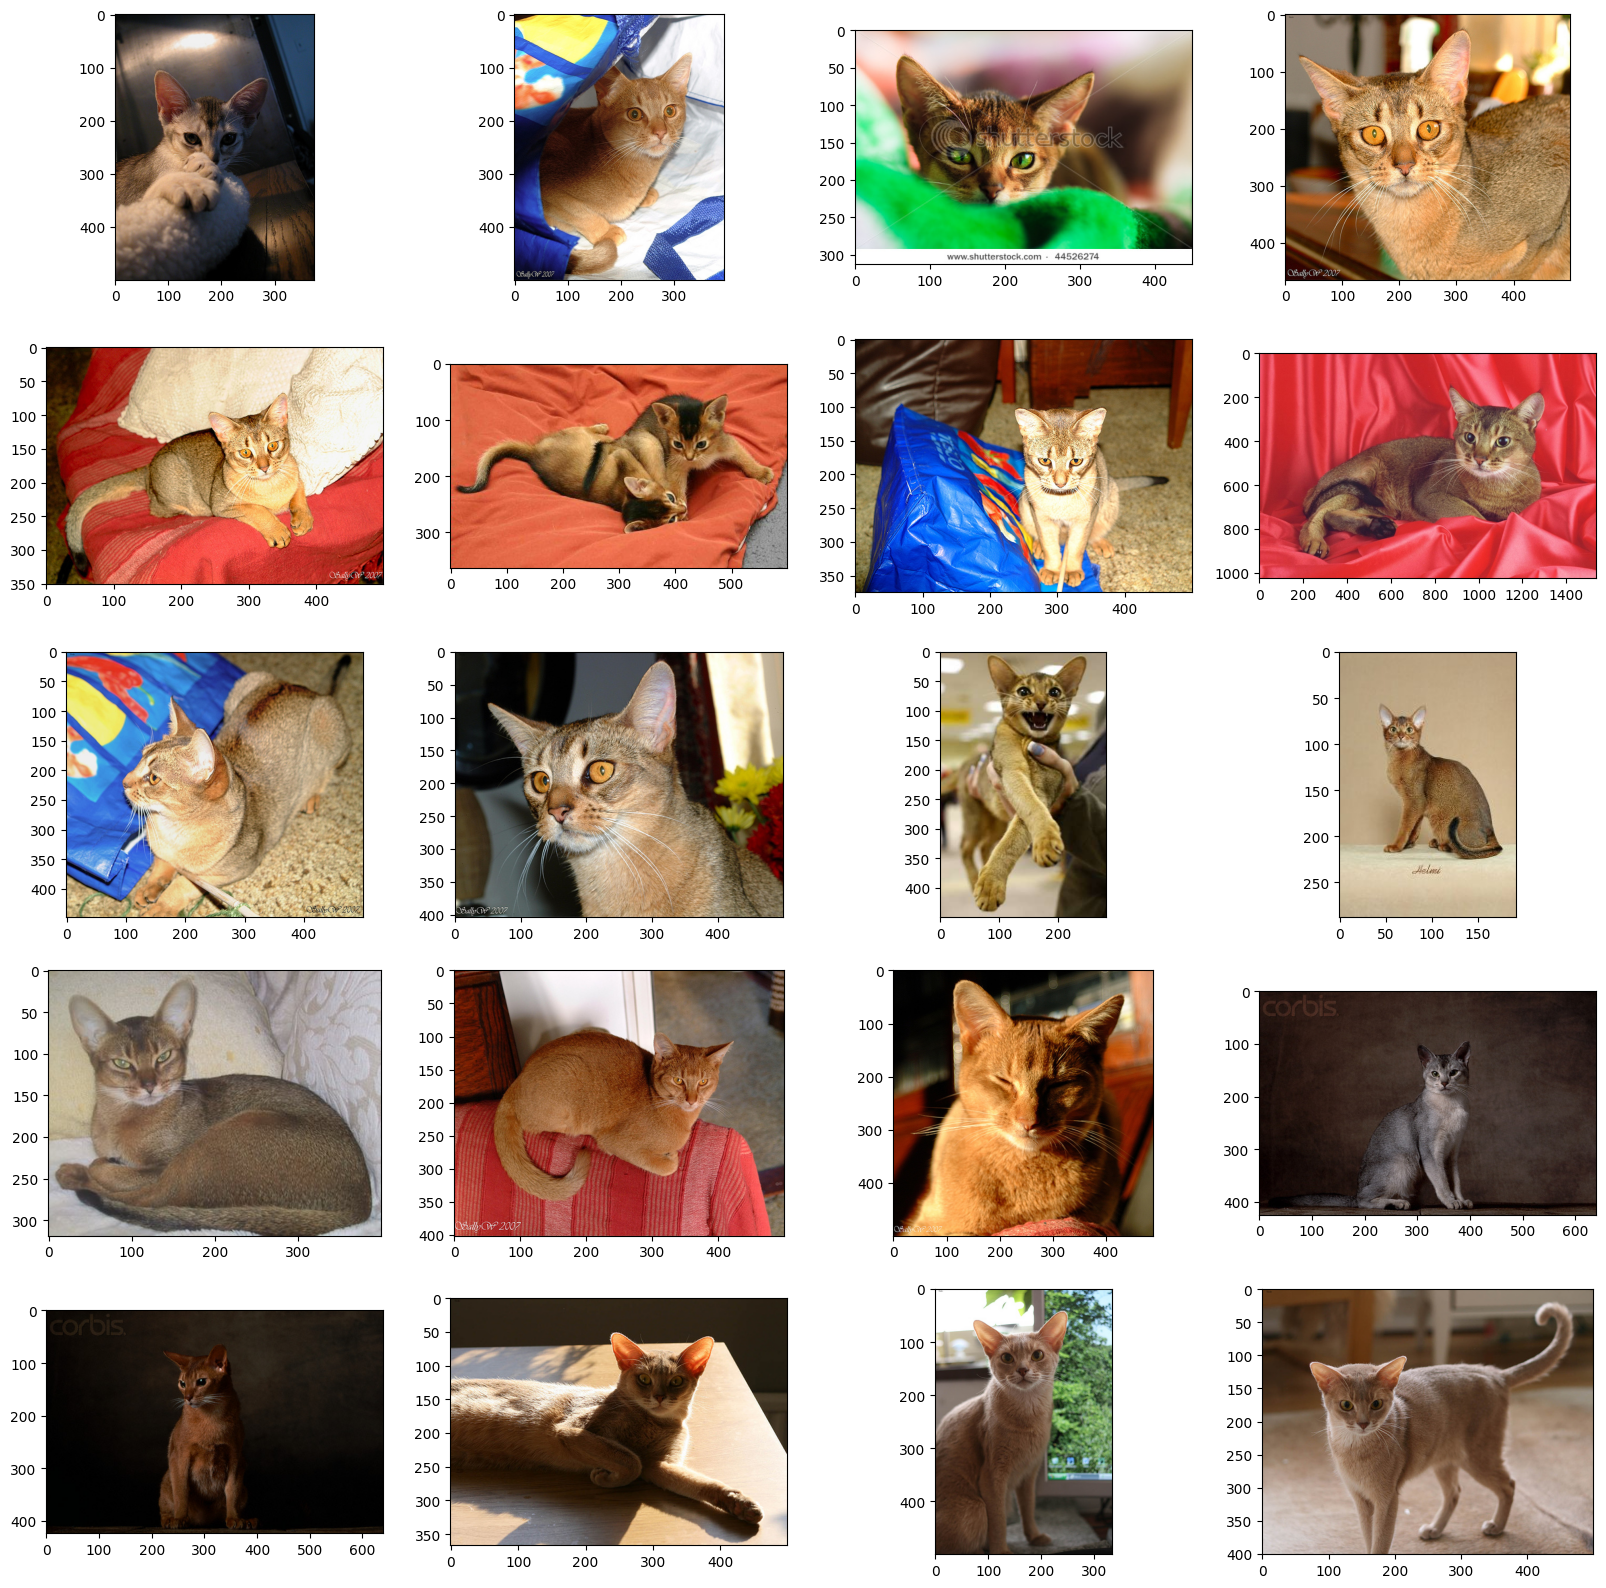

In [14]:
# plot images on a grid. Note this takes ~1min to execute.
import matplotlib.pyplot as plt
from PIL import Image

df = tbl.to_pandas_dataframe()
fig = plt.figure(figsize=(20, 20))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    with df.Path[i].open() as f:
        img = Image.open(f)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)

In [20]:
import time
from azure.ai.ml import MLClient
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes
from azure.identity import DefaultAzureCredential


# connect to the AzureML workspace
# NOTE: subscription_id, resource_group, workspace were set in a previous snippet.
ml_client = MLClient(
    DefaultAzureCredential(), "f804f2da-c27b-45ac-bf80-16d4d331776d",
    "rg-mltable-profiler", "mlw-mltable-profiler"
)

my_data = Data(
    path="./mltable-images",
    type=AssetTypes.MLTABLE,
    description="A sample of cat and dog images",
    name="pets-mltable-images",
    version=VERSION,
)

ml_client.data.create_or_update(my_data)

Uploading mltable-images (0.0 MBs): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 48509.63it/s]


Data({'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': ['azureml://subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourcegroups/rg-mltable-profiler/workspaces/mlw-mltable-profiler/datastores/workspaceblobstore/paths/LocalUpload/e96e8f00a277573a37b4ac32dec5a077/data/images/*.jpg'], 'type': 'mltable', 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'pets-mltable-images', 'description': 'A sample of cat and dog images', 'tags': {}, 'properties': {}, 'print_as_yaml': True, 'id': '/subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourceGroups/rg-mltable-profiler/providers/Microsoft.MachineLearningServices/workspaces/mlw-mltable-profiler/data/pets-mltable-images/versions/2023.09.17.090525', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/alibina1/code/mltable_profiling/ds', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7f400b9a6c20>, 'seri

In [29]:
import mltable
from mltable import MLTable, DataType

# tbl = mltable.from_json_lines_files(paths=[{'file':"./mltable-folder/image_mask.jsonl"}])
tbl = mltable.from_json_lines_files(paths=[{'file':"azureml://subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourcegroups/rg-mltable-profiler/workspaces/mlw-mltable-profiler/datastores/workspaceblobstore/paths/mltable-folder/image_mask.jsonl"}])
# tbl = tbl.convert_column_types({"image_url": DataType.to_stream(), "mask_url": DataType.to_stream()})
df_jsonl = tbl.to_pandas_dataframe()


In [52]:
paths = [{ "file": img_url} for img_url in df_jsonl.image_url]

# create a table from the img paths
tbl = mltable.from_paths(paths)
tbl.save("./mltable-images")


# set the version number of the data asset to the current UTC time
VERSION = time.strftime("%Y.%m.%d.%H%M%S", time.gmtime())
my_data = Data(
    path="./mltable-images",
    type=AssetTypes.MLTABLE,
    description="A sample of cat and dog images",
    name="pets-mltable-images",
    version="1",
)

ml_client.data.create_or_update(my_data)

Data({'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': ['azureml://subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourcegroups/rg-mltable-profiler/workspaces/mlw-mltable-profiler/datastores/workspaceblobstore/paths/LocalUpload/e96e8f00a277573a37b4ac32dec5a077/data/images/Abyssinian_1.jpg', 'azureml://subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourcegroups/rg-mltable-profiler/workspaces/mlw-mltable-profiler/datastores/workspaceblobstore/paths/LocalUpload/e96e8f00a277573a37b4ac32dec5a077/data/images/Abyssinian_10.jpg', 'azureml://subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourcegroups/rg-mltable-profiler/workspaces/mlw-mltable-profiler/datastores/workspaceblobstore/paths/LocalUpload/e96e8f00a277573a37b4ac32dec5a077/data/images/Abyssinian_100.jpg', 'azureml://subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourcegroups/rg-mltable-profiler/workspaces/mlw-mltable-profiler/datastores/workspaceblobstore/paths/LocalUpload/e96e8f00a277573a3

In [54]:
paths = [{ "file": img_url} for img_url in df_jsonl.mask_url]

# create a table from the img paths
tbl = mltable.from_paths(paths)
tbl.save("./mltable-masks")


# set the version number of the data asset to the current UTC time
VERSION = time.strftime("%Y.%m.%d.%H%M%S", time.gmtime())
my_data = Data(
    path="./mltable-masks",
    type=AssetTypes.MLTABLE,
    description="pet masks",
    name="pets-mltable-masks",
    version="2",
)

ml_client.data.create_or_update(my_data)

Uploading mltable-masks (1.94 MBs): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1937245/1937245 [00:00<00:00, 70856466.61it/s]


Data({'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': ['azureml://subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourcegroups/rg-mltable-profiler/workspaces/mlw-mltable-profiler/datastores/workspaceblobstore/paths/LocalUpload/e96e8f00a277573a37b4ac32dec5a077/data/annotations/trimaps/Abyssinian_1.png', 'azureml://subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourcegroups/rg-mltable-profiler/workspaces/mlw-mltable-profiler/datastores/workspaceblobstore/paths/LocalUpload/e96e8f00a277573a37b4ac32dec5a077/data/annotations/trimaps/Abyssinian_10.png', 'azureml://subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourcegroups/rg-mltable-profiler/workspaces/mlw-mltable-profiler/datastores/workspaceblobstore/paths/LocalUpload/e96e8f00a277573a37b4ac32dec5a077/data/annotations/trimaps/Abyssinian_100.png', 'azureml://subscriptions/f804f2da-c27b-45ac-bf80-16d4d331776d/resourcegroups/rg-mltable-profiler/workspaces/mlw-mltable-profiler/datastores/workspaceblobst

In [50]:
print(f"{my_data.name}:{my_data.version}")

pets-mltable-masks:2023.09.17.125920


In [40]:
img_ds = ml_client.data.get("pets-mltable-images", version="2023.09.17.125751")

In [1]:
image_ds = "./data/image"
mask_ds = "./data/anotations/trimaps"

import os